### Setup

In [9]:
# Import main libraries
import os
import json
from bson.objectid import ObjectId
from dotenv import load_dotenv
import pandas as pd
import re
from typing import Annotated, Dict
from typing_extensions import TypedDict, List

# Import LLM, MongoDB etc.
from google import genai

from pymongo import MongoClient
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode, create_react_agent
from langgraph.checkpoint.memory import MemorySaver

# Import LangChain components
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
# Import others
from IPython.display import Image,display



In [16]:
# load API keys from .env
load_dotenv()

True

In [11]:
embedding_model = OpenAIEmbeddings()

In [23]:
mongo_uri = os.getenv('MONGO_URI')
client = MongoClient(mongo_uri)
db = client['insightone']  # Create/use a database named 'insightone'
metadata_full = db['metadata_full']  # Create/use a collection named 'metadata_full'

In [41]:
mlist = metadata_full.find({},{"columns": 1})

In [42]:
mlist2 = []
for m in mlist:
    mlist2.append(m['columns'])

In [ ]:
for d in mlist2:
    print(d.get('columns').get('name'), d.get('columns').get('description', 'No Description Found'))

[{'name': 'employee_id', 'type': 'integer', 'description': 'Unique identifier for each employee', 'examples': [1001, 1002, 1003], 'query_hint': 'WHERE employee_id = 1001'}, {'name': 'department_id', 'type': 'integer', 'description': 'Department where employee works', 'examples': [10, 20, 30], 'query_hint': 'WHERE department_id IN (10,20)'}, {'name': 'hire_date', 'type': 'date', 'description': 'Date when employee was hired', 'examples': ['2020-01-15', '2018-06-22', '2022-03-10'], 'query_hint': "WHERE hire_date > '2020-01-01'"}, {'name': 'job_title', 'type': 'varchar', 'description': "Employee's current job position", 'examples': ['Software Engineer', 'HR Manager', 'Data Analyst'], 'query_hint': "WHERE job_title LIKE '%Engineer%'"}]
[{'name': 'department_id', 'type': 'integer', 'description': 'Unique identifier for each department', 'examples': [10, 20, 30], 'query_hint': 'WHERE department_id BETWEEN 10 AND 30'}, {'name': 'location_id', 'type': 'integer', 'description': 'Physical locatio

In [ ]:
# Connect to MongoDB using MONGODB_URI
mongo_uri = os.getenv('MONGO_URI')
client = MongoClient(mongo_uri)
db = client['insightone']  # Create/use a database named 'insightone'
metadata_full = db['metadata_full']  # Create/use a collection named 'metadata_full'
metadata_chunk = db['metadata_chunk']  # Create/use a collection named 'metadata_chunk'

# Example: Ensure collection exists (MongoDB creates it on first insert)
print('Connected to MongoDB. Ready to use metadata collection.')

Connected to MongoDB. Ready to use metadata collection.


In [110]:
# List of functions

# Create a upload function to metadata from JSON string and upload it to MongoDB
def upload_metadata_json_str(user_id: str, metadata_str: str):
    """
    Upload metadata from a JSON string to MongoDB.
    
    Args:
        metadata_str (str): JSON string containing metadata.
    """
    try:
        # Insert metadata into MongoDB
        db = client["insightone"]
        collection = db[f"user_{user_id}"]
        result = collection.insert_one(metadata_str)
        print(f"Metadata uploaded successfully with ID: {result.inserted_id}")
    except Exception as e:
        print(f"Error uploading metadata: {e}")


# Create a upload function to metadata from a file and upload it to MongoDB
def load_metadata_file(user_id: str, file_path: str): 
    """
    Upload metadata from a file to MongoDB.
    
    Args:
        file_path (str): Path to the file containing metadata in JSON format.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            metadata_str = json.load(file)
        
        # Insert metadata into MongoDB
        upload_metadata_json_str(user_id, metadata_str)
    except Exception as e:
        print(f"Error uploading metadata: {e}")


# Create a function to load data from a file into a JSON string
def load_data_file(file_path: str) -> str:
    """
    Load data from a file into a pandas DataFrame.
    Return sample size of 20 rows for testing purposes.
    
    Args:
        file_path (str): Path to the data file.
        
    Returns:
        pd.DataFrame: Data loaded into a DataFrame.
    """
    try:
        df = pd.read_csv(file_path)
        n_rows = min(20, len(df))
        if n_rows == 0:
            print(f"No data found in {file_path}.")
            return ""
        df_1 = df.sample(n=n_rows, random_state=42) if len(df) > 20 else df
        df_json = df_1.to_json(orient='records', force_ascii=False)
        print(f"Data loaded successfully from {file_path}. Sample size: {n_rows} rows.")
        return df_json
    except Exception as e:
        print(f"Error loading data file: {e}")
        return ""


# Create a function to load additional information from a file to help generate metadata
def load_add_info(file_path: str) -> str:
    """
    Load additional information from a file.
    
    Args:
        file_path (str): Path to the additional info file.
        
    Returns:
        str: Additional information as a string.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            add_info = file.read()
        print(f"Additional info loaded successfully from {file_path}.")
        return add_info
    except Exception as e:
        print(f"Error loading additional info: {e}")
        return ""
    
# Create a function to output metadata from MongoDB
# Note: Need to update to check authority
def read_metadata_collection(user_id: str):
    """
    Read metadata from collection. It will return a list of JSON documents in a string format.
    
    Returns:
        List[dict]: List of metadata documents.
    """
    try:
        db = client["insightone"]
        public_collection = db["metadata_full"]
        user_collection = db[f"user_{user_id}"]

        result = []
        # Retrieve metadata documents from the collection
        for doc in public_collection.find({},{"_id": 0}):
            result.append(doc)
        for doc in user_collection.find({},{"_id": 0}):
            result.append(doc)

        if not result:
            print("No metadata found in the collection.")
            return []
        
        print(f"Retrieved {len(result)} metadata documents from MongoDB.")
        return result
    except Exception as e:
        print(f"Error retrieving metadata: {e}")
        return []

In [116]:
read_metadata_collection("admin")

Retrieved 8 metadata documents from MongoDB.


[{'database': 'HR',
  'table': 'employees',
  'description': 'Stores employee personal and employment information',
  'constraints': {'primary_key': ['employee_id'],
   'foreign_keys': [{'column': 'department_id',
     'references_table': 'departments',
     'references_column': 'department_id'}]},
  'columns': [{'name': 'employee_id',
    'type': 'integer',
    'description': 'Unique identifier for each employee',
    'examples': [1001, 1002, 1003],
    'query_hint': 'WHERE employee_id = 1001'},
   {'name': 'department_id',
    'type': 'integer',
    'description': 'Department where employee works',
    'examples': [10, 20, 30],
    'query_hint': 'WHERE department_id IN (10,20)'},
   {'name': 'hire_date',
    'type': 'date',
    'description': 'Date when employee was hired',
    'examples': ['2020-01-15', '2018-06-22', '2022-03-10'],
    'query_hint': "WHERE hire_date > '2020-01-01'"},
   {'name': 'job_title',
    'type': 'varchar',
    'description': "Employee's current job position"

In [94]:
metadata_list = [doc for doc in metadata_full.find({},{"_id": 0})]

In [100]:
for doc in metadata_full.find({},{"_id": 0}):
    print(doc)

{'database': 'HR', 'table': 'employees', 'description': 'Stores employee personal and employment information', 'constraints': {'primary_key': ['employee_id'], 'foreign_keys': [{'column': 'department_id', 'references_table': 'departments', 'references_column': 'department_id'}]}, 'columns': [{'name': 'employee_id', 'type': 'integer', 'description': 'Unique identifier for each employee', 'examples': [1001, 1002, 1003], 'query_hint': 'WHERE employee_id = 1001'}, {'name': 'department_id', 'type': 'integer', 'description': 'Department where employee works', 'examples': [10, 20, 30], 'query_hint': 'WHERE department_id IN (10,20)'}, {'name': 'hire_date', 'type': 'date', 'description': 'Date when employee was hired', 'examples': ['2020-01-15', '2018-06-22', '2022-03-10'], 'query_hint': "WHERE hire_date > '2020-01-01'"}, {'name': 'job_title', 'type': 'varchar', 'description': "Employee's current job position", 'examples': ['Software Engineer', 'HR Manager', 'Data Analyst'], 'query_hint': "WHERE

In [111]:
# Example: Already have metadata file. Load safety_metadata.json into MongoDB
metadata_path = os.path.join('Data', 'safety_metadata.json')
load_metadata_file("admin", metadata_path)

Metadata uploaded successfully with ID: 687d16f3a0e94f96fd588b57


In [112]:
# Does not have metadata file. Example 1: Load Aircraft metadata

# Open source data file. 
source_data_path = os.path.join('Data', 'Aircraft Table.csv')

# Read CSV into DataFrame and convert to JSON
aircraft_data_json = load_data_file(source_data_path)


Data loaded successfully from Data\Aircraft Table.csv. Sample size: 12 rows.


In [113]:
# Does not have metadata file. Example 2: Load Singapore weather metadata

# Read source data file. Another example: Singapore Weather Table
source_data_path = os.path.join('Data', 'singapore_weather_data.csv')
# Read CSV into DataFrame and convert to JSON
sgweather_data_json = load_data_file(source_data_path)


# Read additional info from weather_data_metadata.txt
add_info_path = os.path.join('Data', 'weather_data_metadata.txt')
weather_add_info = load_add_info(add_info_path)


Data loaded successfully from Data\singapore_weather_data.csv. Sample size: 20 rows.
Additional info loaded successfully from Data\weather_data_metadata.txt.


### Build a Metadata Generator Agent
The Metadata Generator Agent will analyze an uploaded data source and creates metadata using LLM.
In general, the temperature has to be low and the max_output_tokens should be the following:
| **Metadata Detail Level**                                     | **Estimated Tokens** |
| ------------------------------------------------------------- | -------------------- |
| Basic (table + column names/types)                            | 200–400              |
| Moderate (adds descriptions, constraints)                     | 400–800              |
| Detailed (adds query hints, full descriptions, relationships) | 800–1,500+           |
| Complex (multiple tables/relationships)                       | 1,500–3,000+         |

In [119]:
# Set OpenAI model configuration
MODEL_NAME = "gpt-4o"
TEMPERATURE = 0.2
MAX_TOKENS = 2000

# Initialize OpenAI client
llm = ChatOpenAI(model=MODEL_NAME, temperature=TEMPERATURE, max_tokens=MAX_TOKENS)   

In [ ]:
# Functions to create
# Need to port over to metadata_utils.py


In [87]:
# Examples to use.
def multiply(a: int, b: int) -> int:
    """ Multiply a and b
    Args:
        a (int): First number
        b (int): Second number
    Returns:
        int: Product of a and b
    """
    return a * b

In [89]:
multiply_tool = tool(multiply)

In [ ]:
multiply(2, 3)  # Example usage of the multiply function


6

In [93]:
multiply_tool.invoke({"a": 2, "b": 3})

6

In [120]:
# Metadata generation system prompt template for generating metadata from a dataset.
# For system prompt
metadata_generator_system_prompt = """
You are a metadata generation assistant. When provided with a sample dataset (e.g., CSV or relational table), your task is to analyze the data and generate metadata in the following structured JSON format.

### Instructions:
- Infer the primary key by identifying the column(s) that have unique values across all rows (i.e., 100% uniqueness). But fields such as free text and dates may not be suitable for primary keys.
- Detect foreign key relationships based on column names that suggest references (e.g., ending in `_id`, matching a key from another table in same or different collections). Refer to the metadata below for all collections and tables.
- Generate detailed metadata for each column.
- Follow the JSON structure below. Do not include explanations or extra text.
- If there are no suitable examples for a field, use an empty list as appropriate.

### Output JSON structure:

{{
  "database": "<name_of_database>",
  "collection": "metadata_full",  # Use the name of the collection where metadata is stored
  "table": "<name_of_table>",
  "description": "<brief_description_of_table_purpose>",
  "constraints": {{
    "primary_key": ["<column_name1>", "<column_name2>"],
    "foreign_keys": [
      {{
        "column": "<column_name>",
        "references_table": "<referenced_table_name>",
        "references_column": "<referenced_column_name>"
      }}
    ]
  }},
  "columns": [
    {{
      "name": "<column_name>",
      "type": "<data_type>",
      "description": "<meaning_or_purpose_of_column>",
      "examples: ["<example_value1>", "<example_value2>"],
      "query_hint": "<how_to_use_in_where_clause_of_SQL_query>"
    }}
  ]
}}

Use snake_case for all identifiers. You MUST infer the primary key based on uniqueness of values in the provided dataset. Use null if not applicable for any field. Output only the final JSON.

Use the following metadata catalog to inform your analysis and generation of metadata:
{metadata_full_output}

"""

# For user prompt
metadata_info_prompt = """
Generate the metadata for the following dataset:
{sample_data}
"""

add_info_prompt = """
In addition to the above, if you are provided with additional information about the dataset, your task is to incorporate that information into the metadata generation process. This may include:
- Additional context about the dataset
- Specific instructions or constraints that should be reflected in the metadata
- Any other relevant details that can enhance the understanding of the dataset

Below is the additional information you should consider:
{add_info}

"""

In [121]:
def metadata_generator(user_id: str, source_data_json: str, add_info_txt: str = None):
    """
    Generate metadata for one or more datasets using an LLM.
    This function uses the metadata_generator_prompt to create structured metadata.
    Accepts multiple JSON string representations of datasets.
    """

    metadata_list = read_metadata_collection(user_id)
    metadata_json_str = json.dumps(metadata_list, indent=4, ensure_ascii=False)

    # Combine all provided information into one string for the prompt
    system_prompt = metadata_generator_system_prompt.format(
        metadata_full_output=metadata_json_str
    )
    
    user_prompt = metadata_info_prompt.format(sample_data=source_data_json)
    if add_info_txt:
        user_prompt += add_info_prompt.format(add_info=add_info_txt)

    # Input messages for LLM
    messages = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_prompt)
        ]
    
    # Call the LLM with the metadata generation prompt
    response = llm.invoke(messages)

    # Extract the content from AIMessage
    metadata_text = response.content if hasattr(response, 'content') else str(response)
    print("LLM raw response:", metadata_text)

    # Extract JSON object from the response using regex
    match = re.search(r'\{.*\}', metadata_text, re.DOTALL)
    if match:
        json_str = match.group(0)
        try:
            metadata_json = json.loads(json_str)
            print("Metadata generated successfully.")
        except Exception as e:
            print("Error parsing extracted JSON:", e)
            print("Extracted JSON was:\n", json_str)
            return None
    else:
        print("No JSON object found in LLM response. Unable to generate metadata")
        print("LLM response was:\n", metadata_text)
        return None

    return metadata_json


In [122]:
# Generate metadata for the aircraft dataset
aircraft_metadata = metadata_generator("admin", aircraft_data_json)

Retrieved 8 metadata documents from MongoDB.
LLM raw response: {
  "database": "Aircraft",
  "collection": "metadata_full",
  "table": "aircraft_specifications",
  "description": "Contains specifications and details of various aircraft models, including their roles, capacities, and notable models.",
  "constraints": {
    "primary_key": ["aircraft_type"],
    "foreign_keys": []
  },
  "columns": [
    {
      "name": "aircraft_type",
      "type": "varchar",
      "description": "The type of aircraft, serving as a unique identifier for each record.",
      "examples": ["Airbus", "Boeing"],
      "query_hint": "WHERE aircraft_type = 'Airbus'"
    },
    {
      "name": "manufacturer",
      "type": "varchar",
      "description": "The company that manufactures the aircraft.",
      "examples": ["Airbus SE", "Boeing"],
      "query_hint": "WHERE manufacturer = 'Boeing'"
    },
    {
      "name": "typical_role",
      "type": "varchar",
      "description": "The typical role or primary u

In [40]:
# Load generated aicraft metadata into MongoDB
upload_metadata_json_str(aircraft_metadata)

Metadata uploaded successfully with ID: 687cb04ea0e94f96fd588b54


In [43]:
# Generate metadata for the SG weather dataset with additional info
sgweather_metadata = metadata_generator(sgweather_data_json, weather_add_info)

Retrieved 7 metadata documents from MongoDB.
LLM raw response: ```json
{
  "database": "Weather",
  "table": "daily_weather",
  "description": "Daily weather observations including temperature, humidity, pressure, visibility, wind, precipitation, and events from 2013-12-21 to 2017-07-31.",
  "constraints": {
    "primary_key": ["date"],
    "foreign_keys": []
  },
  "columns": [
    {
      "name": "date",
      "type": "date",
      "description": "Date of the weather observation in YYYY-MM-DD format.",
      "examples": ["2015-10-29", "2016-11-01"],
      "query_hint": "WHERE date = '2015-10-29'"
    },
    {
      "name": "temp_high_f",
      "type": "integer",
      "description": "High temperature of the day in Fahrenheit.",
      "examples": [81, 91],
      "query_hint": "WHERE temp_high_f > 90"
    },
    {
      "name": "temp_avg_f",
      "type": "integer",
      "description": "Average temperature of the day in Fahrenheit.",
      "examples": [66, 81],
      "query_hint": "WH

In [44]:
# Load generated SG weather metadata into MongoDB
upload_metadata_json_str(sgweather_metadata)

Metadata uploaded successfully with ID: 687cb1aea0e94f96fd588b55


### Build a Metadata Query Agent
The Metadata Query Agent will analyze the query to suggest the tables and columns to use

In [ ]:
# Metadata generation system prompt template for generating metadata from a dataset.
# Escape curly braces for .format(), except for the data sample placeholder
metadata_query_system_prompt = """
You are a metadata query assistant. Your role is to help users understand the available data structures and guide them toward the right tables, columns, and relationships based on their queries.

You are provided with a metadata catalog (formatted as JSON) that includes databases, tables, columns, descriptions, relationships (primary/foreign keys), and query hints. Use this information to answer user queries in natural language.

### Instructions:
- Interpret the user query and identify the user's intent.
- Search the metadata for relevant tables and columns that could help answer the user’s question.
- If matching tables/columns exist, explain:
  - Which table(s) are relevant and why.
  - What useful columns are included in those tables.
  - What relationships exist between these tables (e.g., foreign keys).
  - Suggestions for how the user might combine or explore the data further.
- If the metadata doesn't include any relevant tables or fields, clearly inform the user that the requested data is not available.
- Be helpful and proactive — suggest potentially useful related tables when appropriate (e.g., weather, aircraft specs, etc.).
- Never make up table or column names that don't exist in the metadata.
- Be concise, clear, and informative.

### Metadata Catalog:
{metadata_full_output}

"""



In [46]:
# HARDCODED EXAMPLES. Need to pull from MongoDB and user query from frontend

user_query = "I want to know the incidents for different aircraft over the years"


In [81]:
@tool
def metadata_query(user_query: str):
    """
    Query the metadata catalog to find relevant tables and columns based on a user query.
    
    Args:
        user_query (str): The user's query asking for specific data or insights.
        metadata_json (str): JSON string containing the metadata catalog.
    Returns:
        str: Response containing relevant tables, columns, and relationships.
    """
    
    # Create the system prompt
    system_prompt = metadata_generator_system_prompt.format(
        metadata_full_output=read_metadata_collection()
    )

    # Prepare the user query
    user_prompt = user_query
    
    # Input messages for LLM
    messages = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_prompt)
        ]
    
    # Call the LLM with the metadata query prompt
    response = llm.invoke(messages)

    # Extract the content from AIMessage
    return response.content if hasattr(response, 'content') else str(response)

## test function
@tool
def multiply(a: int, b: int) -> int:
    """ Multiply a and b
    Args:
        a (int): First number
        b (int): Second number
    Returns:
        int: Product of a and b
    """
    return a * b

# Create list of tools
tools = [metadata_query, multiply]

NameError: name 'create_react_agent' is not defined

In [ ]:
# Create a state class for the metadata query
class MetadataQueryState(TypedDict):
    messages:Annotated[list, add_messages]

# Store memory
memory=MemorySaver()

# Bind tools
llm.bind_tools(tools)

# Node definition
def call_llm(state: MetadataQueryState):
    return {"messages":[llm.invoke(state["messages"])]}

# Graph
graph_builder = StateGraph(MetadataQueryState)

# Add nodes
graph_builder.add_node("call_llm",call_llm)
# graph_builder.add_node("metadata_query",metadata_query)
graph_builder.add_node("tools", ToolNode(tools))

## Add edges
graph_builder.add_edge(START, "call_llm")
graph_builder.add_conditional_edges(
    "call_llm",
    # If the latest message (result) from assistance is a tool call -> tools_condition route to tools
    # If the latest message (result) from assistance is not a tool call -> tools_condition route to END
   tools_condition 
)
graph_builder.add_edge("tools", "call_llm")
# graph_builder.add_edge("call_llm", "metadata_query")
# graph_builder.add_edge("metadata_query", END)

## compile the graph
graph=graph_builder.compile(checkpointer=memory)

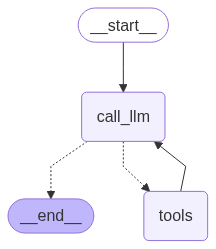

In [66]:
# Print out the graph structure
display(Image(graph.get_graph().draw_mermaid_png()))

In [67]:
config={"configurable":{"thread_id":"3"}}

response = graph.invoke({"messages":"I want to know the incidents for different aircraft over the years using my metadata. I also want to know 2 multiply by 5"}, config=config)

for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

I want to know the incidents for different aircraft over the years using my metadata. I also want to know 2 multiply by 5
================================== Ai Message ==================================

To analyze incidents for different aircraft over the years using your metadata, you would typically need to organize your data in a way that allows you to track incidents by aircraft type and year. This could involve creating a database or spreadsheet where you can input and categorize your data. Here’s a general approach you might take:

1. **Data Collection**: Gather all relevant data regarding aircraft incidents. This could include the date of the incident, aircraft type, location, cause, and any other pertinent details.

2. **Data Organization**: Organize your data into a structured format. A spreadsheet or database table with columns for each data point (e.g., Year, Aircraft Type, Incident Descriptio

In [64]:
response

{'messages': [HumanMessage(content='I want to know the incidents for different aircraft over the years using my metadata. I also want to know 2 multiply by 5', additional_kwargs={}, response_metadata={}, id='d5e12a53-12ab-4fd3-abaf-dad0b685a1be'),
  AIMessage(content='To analyze incidents for different aircraft over the years using your metadata, you would typically need to have a dataset that includes details such as the aircraft type, date of incidents, and possibly other relevant information like location, cause, and severity. You can then use data analysis tools or software to process this metadata and extract insights, such as trends over time, common types of incidents for specific aircraft, and so on.\n\nIf you have specific metadata, you can use tools like Excel, Python (with libraries such as pandas and matplotlib), or R to perform this analysis. You would load your data into the tool, clean and preprocess it as necessary, and then perform analyses like counting incidents per 

In [67]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

I want to know the incidents for different aircraft over the years
================================== Ai Message ==================================

To provide a comprehensive overview of aircraft incidents over the years, it's important to note that aviation safety has improved significantly over time, but incidents still occur due to various factors such as mechanical failure, human error, weather conditions, and other unforeseen circumstances. Here's a general overview of some notable incidents involving different types of aircraft over the decades:

### 1950s-1960s
- **De Havilland Comet**: The world's first commercial jetliner, the Comet suffered several high-profile crashes in the early 1950s due to metal fatigue, leading to significant design changes in future aircraft.
- **Lockheed Constellation**: Experienced several accidents, often related to engine failures and weather conditions.

### 1970s
-

In [68]:
response = graph.invoke({"messages":"I want to use the metadata. This LLM has a tool that queries my metadata"}, config=config)
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

I want to know the incidents for different aircraft over the years
================================== Ai Message ==================================

To provide a comprehensive overview of aircraft incidents over the years, it's important to note that aviation safety has improved significantly over time, but incidents still occur due to various factors such as mechanical failure, human error, weather conditions, and other unforeseen circumstances. Here's a general overview of some notable incidents involving different types of aircraft over the decades:

### 1950s-1960s
- **De Havilland Comet**: The world's first commercial jetliner, the Comet suffered several high-profile crashes in the early 1950s due to metal fatigue, leading to significant design changes in future aircraft.
- **Lockheed Constellation**: Experienced several accidents, often related to engine failures and weather conditions.

### 1970s
-

In [65]:
docs = metadata_full.find({}, {"_id": 0}) 
for doc in docs:
    print(doc)

{'database': 'airspace', 'collection': 'metadata_full', 'table': 'safety', 'description': 'Each record represents a single safety incident reported for aircraft operations, including failure parts, incident nature, precautionary actions, and contextual metadata such as date, location, and airline group/unit responsible.', 'constraints': {'primary_key': ['report_id'], 'foreign_keys': []}, 'columns': [{'name': 'date', 'type': 'DATE', 'description': 'Date of the incident in YYYY-MM-DD format. Range: 2020-01-01 to 2020-12-31.', 'examples': ['2020-01-15', '2020-06-30', '2020-11-05'], 'query_hint': 'Useful for filtering incidents by time period or aggregating counts over days, months, or quarters.'}, {'name': 'report', 'type': 'TEXT', 'description': 'A textual summary describing the incident details.', 'examples': ['ENGINE FAILURE DURING TAKEOFF, FUEL LEAK DETECTED', 'FUSELAGE CRACKED, EMERGENCY LIGHTS INOPERATIVE', 'ZONE 100 CORRODED, UNSCHED LANDING REQUIRED'], 'query_hint': "Use LIKE or f

In [42]:
test = metadata_query(user_query, metadata_from_MongoDB)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8772\3658160504.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  test = metadata_query(user_query, metadata_from_MongoDB)


AttributeError: 'str' object has no attribute 'parent_run_id'

In [73]:
sentences = test.split('. ')
for sentence in sentences:
    print(sentence.strip() + '.')

To explore incidents for different aircraft over the years, you can refer to the `safety` table in the metadata catalog.
This table contains records of safety incidents reported for aircraft operations.
Here are the relevant details:

- **Table**: `safety`
  - **Relevant Columns**:
    - `date`: This column provides the date of the incident, which you can use to filter or aggregate incidents over specific time periods (e.g., by year).
    - `aircraft_type`: This column indicates the type of aircraft involved in the incident, allowing you to group or filter incidents by aircraft type.
    - `report`: A textual summary describing the incident details.
    - `part_failure`: Specific part or system that failed during the incident.
    - `occurence_nature_condition`: Describes the nature or condition of the incident occurrence.
    - `occurence_precautionary_procedures`: Records any precautionary or emergency procedures taken in response to the incident.

You can query this table to get inc